Importing Libraries

In [17]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense,Conv3D, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import matplotlib.pyplot as plt
import keras
from keras import regularizers
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.optimizers import SGD
#import keras_cv

from keras.models import Model
from keras import backend as K
import tensorflow.keras.layers as layers
import tensorflow.keras.models
from keras.applications.inception_v3 import InceptionV3

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_root='/Users/faizahkureshi/Desktop/Capstone Project/Images'

IM_WIDTH=224
IM_HEIGHT=224
batch_size=64

ori_datagen = ImageDataGenerator(
    rescale=1./255)

print('Original Data : ')
original_data = ori_datagen.flow_from_directory(
    train_root,
    target_size = (256,256),
    class_mode = 'categorical'
)

Original Data : 
Found 15620 images belonging to 67 classes.


To Create Dataset and Preprocessing

In [12]:
a = original_data.class_indices
class_name = dict((v,k) for k,v in a.items())
class_name

{0: 'airport_inside',
 1: 'artstudio',
 2: 'auditorium',
 3: 'bakery',
 4: 'bar',
 5: 'bathroom',
 6: 'bedroom',
 7: 'bookstore',
 8: 'bowling',
 9: 'buffet',
 10: 'casino',
 11: 'children_room',
 12: 'church_inside',
 13: 'classroom',
 14: 'cloister',
 15: 'closet',
 16: 'clothingstore',
 17: 'computerroom',
 18: 'concert_hall',
 19: 'corridor',
 20: 'deli',
 21: 'dentaloffice',
 22: 'dining_room',
 23: 'elevator',
 24: 'fastfood_restaurant',
 25: 'florist',
 26: 'gameroom',
 27: 'garage',
 28: 'greenhouse',
 29: 'grocerystore',
 30: 'gym',
 31: 'hairsalon',
 32: 'hospitalroom',
 33: 'inside_bus',
 34: 'inside_subway',
 35: 'jewelleryshop',
 36: 'kindergarden',
 37: 'kitchen',
 38: 'laboratorywet',
 39: 'laundromat',
 40: 'library',
 41: 'livingroom',
 42: 'lobby',
 43: 'locker_room',
 44: 'mall',
 45: 'meeting_room',
 46: 'movietheater',
 47: 'museum',
 48: 'nursery',
 49: 'office',
 50: 'operating_room',
 51: 'pantry',
 52: 'poolinside',
 53: 'prisoncell',
 54: 'restaurant',
 55: 'r

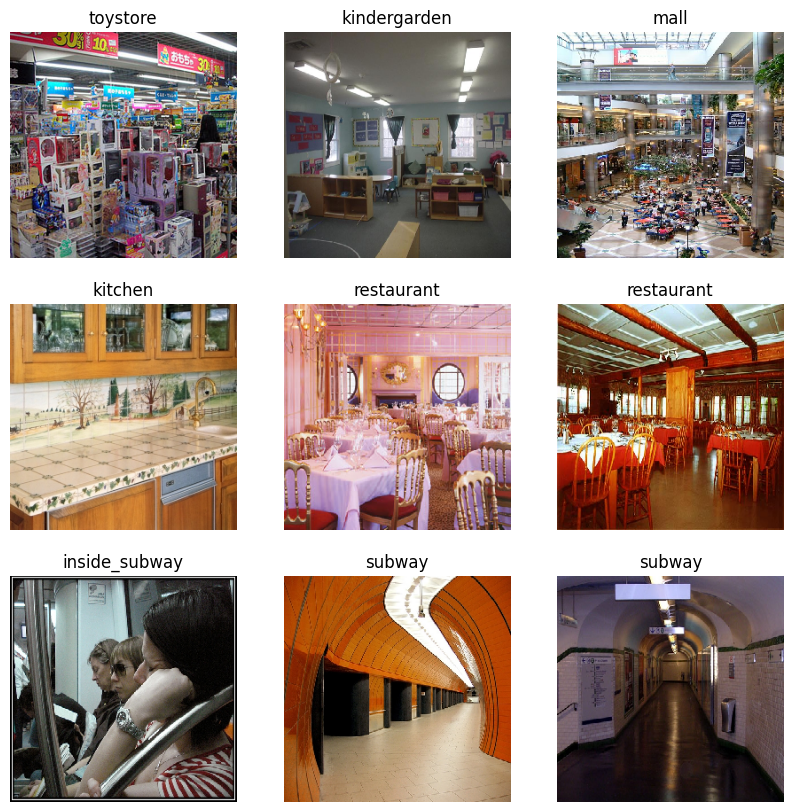

In [13]:
plt.figure(figsize=(10, 10))
x,y= original_data.next()
for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(x[i])
      plt.title(class_name[np.argmax(y[i])])
      plt.axis("off")

Creating Test and train dataset

In [18]:
datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2,
)
print('Training Data : ')
train_generator = datagen.flow_from_directory(
  train_root,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
  class_mode='categorical', subset='training')

print('Validation Data : ')
vaild_generator = datagen.flow_from_directory(
  train_root,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=batch_size,
  class_mode='categorical', subset='validation')

Training Data : 
Found 12522 images belonging to 67 classes.
Validation Data : 
Found 3098 images belonging to 67 classes.


Building Model

CallBacks

In [19]:
accuracy_threshold = 92e-2
class my_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('accuracy') >= accuracy_threshold and logs.get('val_accuracy') >= accuracy_threshold :
            print('\nFor Epoch', epoch, '\nAccuracy has reach = %2.2f%%' %(logs['accuracy']*100), 'training has been stopped.')
            self.model.stop_training = True

In [20]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

CALLBACKS = [early_stopping_callback, reduce_lr_callback, my_callbacks()]

EfficientNet B3

In [23]:
import ssl
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout

# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

# Create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='max'
)

# Define your model architecture
model = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3), name='inputLayer'),
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(67, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 67)                17219     
                                                                 
Total params: 4399846 (16.78 MB)
Trainable params: 435

In [27]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            name = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(name)


2-conv-128-nodes-4-dense-1707971347


Training

In [28]:
# training
history = model.fit_generator(train_generator,
                    epochs=10,
                    validation_data=vaild_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(vaild_generator),
                    verbose=1,
                    callbacks=CALLBACKS)

Epoch 1/10
196/196 [==============================] - 1325s 7s/step - loss: 6.7528 - accuracy: 0.4275 - val_loss: 3.6407 - val_accuracy: 0.6210 - lr: 0.0010
Epoch 2/10
196/196 [==============================] - 1364s 7s/step - loss: 2.5012 - accuracy: 0.7263 - val_loss: 2.1792 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 3/10
196/196 [==============================] - 1216s 6s/step - loss: 1.6027 - accuracy: 0.8154 - val_loss: 1.9306 - val_accuracy: 0.6943 - lr: 0.0010
Epoch 4/10
196/196 [==============================] - 1023s 5s/step - loss: 1.2812 - accuracy: 0.8667 - val_loss: 1.8297 - val_accuracy: 0.7108 - lr: 0.0010
Epoch 5/10
196/196 [==============================] - 860s 4s/step - loss: 1.1379 - accuracy: 0.8875 - val_loss: 1.8030 - val_accuracy: 0.7101 - lr: 0.0010
Epoch 6/10
196/196 [==============================] - 780s 4s/step - loss: 1.0687 - accuracy: 0.9006 - val_loss: 1.8073 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 7/10
196/196 [==============================] - ETA: 0

Plotting accuray graph

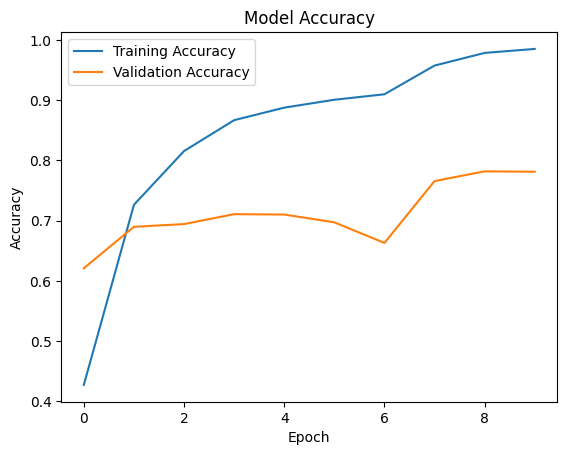

In [29]:
# Plot accuracy graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 494ms/step


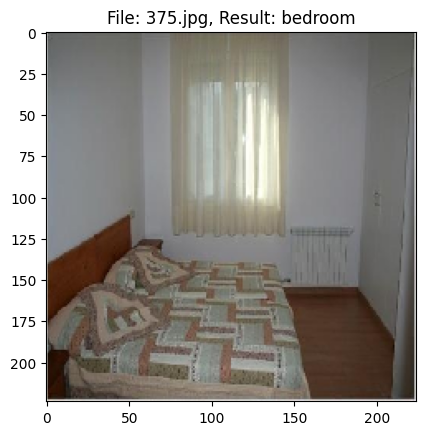

1/1 [==============================] - 0s 53ms/step


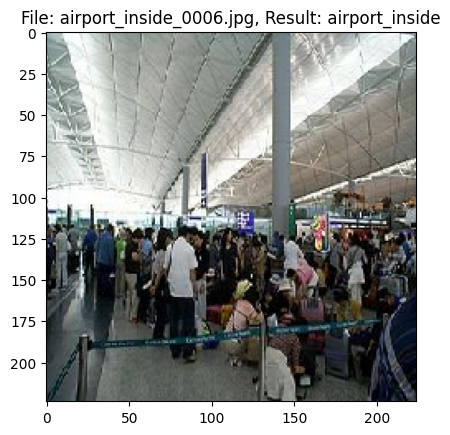

1/1 [==============================] - 0s 49ms/step


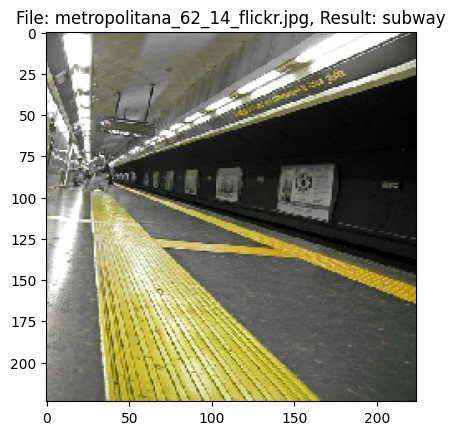

1/1 [==============================] - 0s 71ms/step


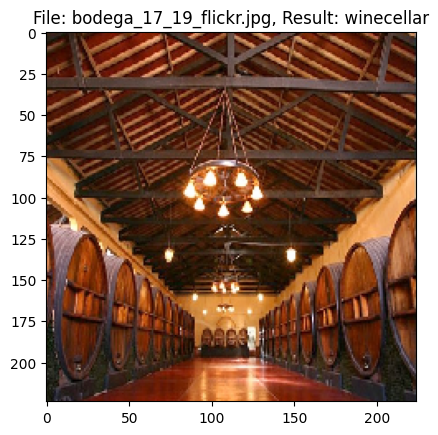

1/1 [==============================] - 0s 41ms/step


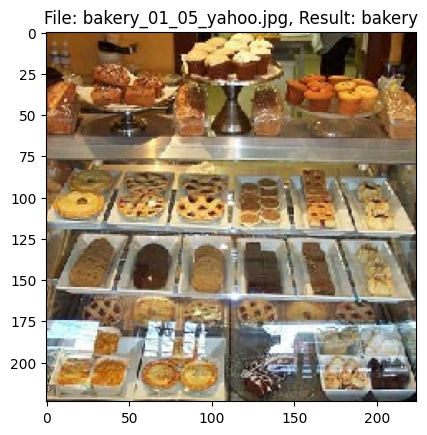

In [30]:
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageOps

folder_path = '/Users/faizahkureshi/Desktop/Capstone Project/test_img'

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):  # Assuming all files are JPEG images
        # Construct the full path to the image
        img_path = os.path.join(folder_path, filename)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])

        # Make predictions
        classes = model.predict(images, batch_size=10)
        result = class_name[np.argmax(classes)]

        # Plot the image
        plt.imshow(img)
        plt.title(f"File: {filename}, Result: {result}")
        plt.show()

XAI  

Load and preprocess the image

In [31]:
import PIL
import numpy as np
import requests

import PIL
import numpy as np

def get_processed_img(file_path):
    # Open the image from file path
    img_from_file = PIL.Image.open(file_path)
    
    # Adjust the image dimensions to a standard size.
    new_image = img_from_file.resize((224, 224))
    
    # Transform the image into a NumPy array.
    processed_image = np.asarray(new_image)
    
    # Normalize pixel values if necessary
    if processed_image.max() > 1:
        processed_image = processed_image / 255
    
    # Add a batch dimension
    image = np.expand_dims(processed_image, axis=0)
    
    return image


Creating GAad-CAM MODEL

In [32]:
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a sub-model that outputs the feature maps and final prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to record gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        
        # If pred_index is not specified, use the predicted class index
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalise the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

Calcuclate the Gradients
1. Feed the input image to the trained model.
2. Calculate the result of the final convolutional layer.
3. Compute the gradient of the output of the last convolutional layer with respect to the target concept.
4. Take a global average pooling of the gradient map.

Generate Heatmap - With the gradients in hand, we combine them with the feature maps of the chosen layer to create the Grad-CAM heatmap. The heatmap highlights the regions of the image that are most influential in making a particular prediction. Normalize the heatmap values to be between 0 and 1.

Display Heatmap

In [33]:
import matplotlib.pyplot as plt
from matplotlib import cm

def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range of 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use the "jet" colormap to colourize the heatmap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Transform the heatmap into an image.
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    
    # Resize the heatmap to match the image dimensions
    jet_heatmap = jet_heatmap.resize((img.shape[2], img.shape[1]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    plt.imshow(superimposed_img[0])

show the heatmap

In [36]:
from tensorflow.keras.applications import EfficientNetB3

# Load the EfficientNet B3 model
efficientnet_b3_model = EfficientNetB3(weights='imagenet', include_top=False)

# Display the summary of the model to find the name of the last convolutional layer
print(efficientnet_b3_model.summary())


43941136/43941136 [==============================] - 15s 0us/step
Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, None, None, 3)        0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, None, None, 3)        7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Resca

In [39]:
# Get the name of the last convolutional layer in the EfficientNet B3 model
last_conv_layer_name = 'block4d_project_conv[0][0]'

# Generate the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_arr, model, last_conv_layer_name)

# Display the heatmap
plt.axis('off')
plt.matshow(heatmap)
plt.show()


ValueError: No such layer: block4d_project_conv[0][0]. Existing layers are: ['efficientnetb0', 'batch_normalization_1', 'dense_7', 'dropout_2', 'dense_8'].

In [35]:
img_arr = get_processed_img('/Users/faizahkureshi/Desktop/Capstone Project/test_img/airport_inside_0006.jpg')

heatmap = make_gradcam_heatmap(img_arr, model, '2-conv-128-nodes-4-dense')

plt.axis('off')
plt.matshow(heatmap)
plt.show()

ValueError: No such layer: 2-conv-128-nodes-4-dense. Existing layers are: ['efficientnetb0', 'batch_normalization_1', 'dense_7', 'dropout_2', 'dense_8'].